In [1]:
#ARIMAS
import sys
sys.path.append("../getData")
sys.path.append("../../visualization")
sys.path.append("../functions")
import bdStocks
import graficosJupyterNotebook as graficos
import numpy as np
import pandas as pd
import transformationsDataframes
pd.set_option('display.max_rows', None)
import scipy.stats
import statsmodels.stats.diagnostic
import statsmodels.api as sm
import math
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import acf
import warnings
warnings.filterwarnings("ignore")

In [106]:
from scipy.stats import norm
sigma2=1
coef2=[]
coef=[0.4,0.4]
n=100
serie=np.zeros(n)
for i in range(len(coef)):
    serie[i]=1
acumulado=np.zeros(n)
for i in range(len(coef),len(serie)):
    acumulado[i]=norm.rvs()
    serie[i]+=acumulado[i]
    """for l in range(len(coef)):
        serie[i]+=serie[i-1-l]*coef[l]
    for l in range(len(coef2)):
         serie[i]+=coef2[l]*acumulado[i-1-l]"""
    serie[i]+=serie[i-1]*coef[0]+serie[i-4]*coef[1]+serie[i-5]*coef[0]*coef[1]
dti = pd.date_range("2018-01-01", periods=len(serie), freq="D")
serie=pd.DataFrame(serie)
serie.index=dti
serie_train=serie[0][:n-int(n*0.1)]
serie_test=serie [0][n-int(n*0.1):]
serie_train=pd.Series(serie_train).dropna()
serie_test=pd.Series(serie_test).dropna()
#serie_test.index=range(len(serie_train),len(serie_train)+len(serie_test))

0 0


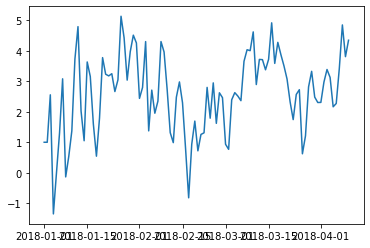

In [119]:
from statsmodels.tsa.stattools import adfuller
#la hipotesis nula es que hay raiz unitaria
diferenciacion=0
diferenciacionEstacional=0
estacional=True
paramFuller=5


adf=adfuller(serie_train,maxlag=max_lag)
adf
posibleEstacionaridad=False
diferenciacion=0
diferenciacionEstacional=0
if adf[1]>nivel_confianza:
    posibleEstacionaridad=True
    
if posibleEstacionaridad and estacional:
    serie1=pd.Series(serie_train).diff(periodicidad).dropna()
    adf1=adfuller(serie1,maxlag=max_lag)
if posibleEstacionaridad:
    serie2=pd.Series(serie_train).diff(1).dropna()
    adf2=adfuller(serie2,maxlag=max_lag)
    print(adf1,adf2)
if posibleEstacionaridad and estacional:
    for k in ["1%","5%"]:
        if adf2[0]<adf1[4][k]:
            if adf1[0]<adf1[4][k]:
                if adf1[1]<0.005:
                    diferenciacionEstacional=1
                    
                else:
                    diferenciacion=1
                  

            else:
                diferenciacion=1
                
            break
    if diferenciacion==0 and diferenciacionEstacional==0:
            serie3=pd.Series(serie1).diff(1).dropna()
            adf3=adfuller(serie3,maxlag=max_lag)
            print(adf3)
            if adf3[0]<adf3[4]["5%"]:
                diferenciacionEstacional=1
                diferenciacion=1
            else:
                serie_train=None

print(diferenciacion,diferenciacionEstacional)
        
import matplotlib.pyplot as plt
plt.plot(serie)

100
0.1
[10.          5.36840444  2.45705723  2.74948305  4.07006678  3.38119893
  1.34687299  0.03651865  0.43108066  1.18408511  0.90503419  0.32616047
  0.44562967  0.23608079  0.19002817  0.99391554  2.1554229   2.53294458
  2.42619513  2.06129841  2.96459483  4.17816456  3.91100174  2.87206299
  2.18526612  2.73482322  3.35353391  2.36573941  1.37928435  0.97800949
  1.27570407] [10.          5.42872359  0.61564007  2.46270706  2.65379056  0.16188858
  1.26583383  1.66935572  0.21684957  0.48171362  0.58077423  0.39672275
  0.32711657  0.06297203  1.58981762  0.85779052  2.3730392   1.79211289
  1.31100257  0.35758171  1.28048579  2.43509167  1.58685303  1.49852898
  0.04917258  1.24809736  1.81228331  0.29940711  1.45559829  0.08595762
  0.31734876]
2.3263478740408408


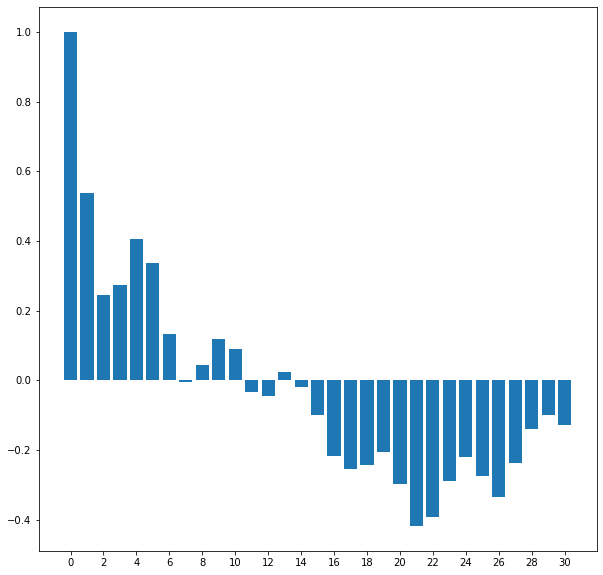

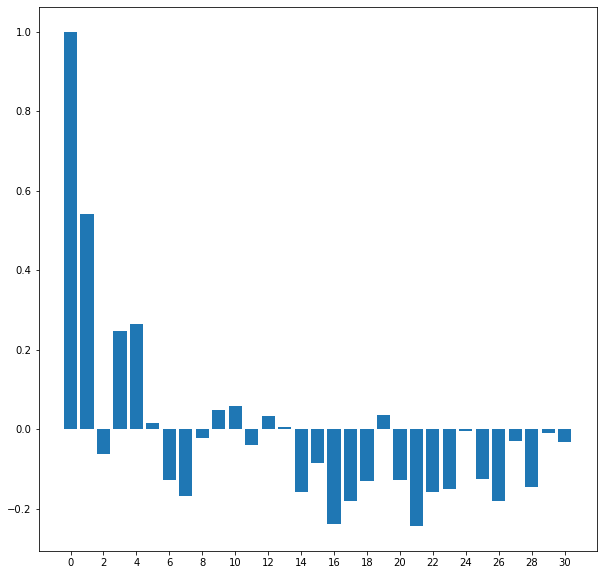

In [120]:
import scipy.stats
import statsmodels.stats.diagnostic
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
serie1=serie_train.copy()
if diferenciacion and  diferenciacionEstacional:
    serie1=serie_train.diff(periodicidad).diff(1)
elif diferenciacion:
    serie1=serie_train.diff(1)
elif diferenciacionEstacional:
    serie1=serie_train.diff(periodicidad)
serie1=serie1.dropna() 
corr=acf(serie1,nlags=int(len(serie1)/3))
pcorr=pacf(serie1,nlags=int(len(serie1)/3))
nivel=norm.ppf(0.99)
def devolverEstadisticos(corr,pcorr,diferenciacion,serie):
    T=len(serie)-diferenciacion
    print(T)
    varSerie=1/T
    desv=math.sqrt(varSerie)
    print(desv)
    return abs(corr)/desv,abs(pcorr)/desv
estCorr,estPcorr=(devolverEstadisticos(corr,pcorr,diferenciacion,serie))
print(estCorr,estPcorr)
print(nivel)
graficos.correlograma(corr,pcorr)

In [121]:
def contrasteCorrelacionResiduos(serie,diferenciacion,nivel_confianza):
    T=len(serie)-diferenciacion
    varSerie=1/T
    desv=math.sqrt(varSerie)
    nivel=norm.ppf(1-nivel_confianza/2)
    a= abs(serie)/desv<nivel

    return a

class Modelo:
    def __init__(self,modelo,modeloExtendido,significacionP=None,significacionQ=None,significacionPEst=None,significacionQEst=None):
        self.modelo=modelo
        self.modeloExtendido=modeloExtendido
        self.errorTrain=modelo.mse
        self.errorTest=modeloExtendido.mse
        self.aicTrain=modelo.aic
        self.aicTest=modeloExtendido.aic
        self.aicTotal=ponderaciones[0]+self.aicTrain+ponderaciones[1]*self.aicTest
        self.errorTotal=ponderaciones[0]+self.errorTrain*ponderaciones[1]*self.errorTest
        self.significacionP=significacionP
        self.significacionQ=significacionQ
        self.significacionPEst=significacionPEst
        self.significacionQEst=significacionQEst
def crearYProbarModelo(serie_train,serie_test,ordenes=None,ordenesSeason=None,diferenciacion=0,diferenciacionSeason=0,periodo=None):
    modelo=None
    notSeasonalTrend="c"
    seasonalTrend="c"
    if diferenciacion>0:
        notSeasonalTrend="t"
    if diferenciacionSeason>0:
        seasonalTrend="t"
        if ordenesSeason is None:
            ordenesSeason=(0,0)
        
    if  ordenes is not None:
        ordenes=(ordenes[0],diferenciacion,ordenes[1])
    if  ordenes is not None and ordenesSeason is not None:
        ordenesSeason=(ordenesSeason[0],diferenciacionSeason,ordenesSeason[1],periodo)
    if ordenesSeason is not None:
           ordenesSeason=(ordenesSeason[0],diferenciacionSeason,ordenesSeason[1],periodo)
    if  ordenes is not None and ordenesSeason is not None:   
        s="c"
        if notSeasonalTrend=="t" or  seasonalTrend=="t":
            s="t"
       
        modelo=ARIMA(endog=serie_train,order=ordenes,seasonal_order=ordenesSeason)
    elif ordenes is not None:
        modelo=ARIMA(endog=serie_train,order=ordenes,trend=notSeasonalTrend)
    elif ordenesSeason is not None:
        modelo=ARIMA(endog=serie_train,seasonal_order=ordenesSeason,trend= seasonalTrend)
    if modelo is not None:    
    
        adj=modelo.fit()
        adj2=adj.extend(serie_test.to_numpy())
        
        return adj,adj2

In [122]:
from scipy.stats import norm
import itertools
import scipy.stats
import statsmodels.stats.diagnostic
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import acf

def reglas(serie_train,serie_test,estCorr,estPcorr,nivel_confianza,diferenciacion,diferenciacionSeason):
    nivel=norm.ppf(1-nivel_confianza/2)
    ordenesp={}
    ordenesq={}
    ordenespEstacional={}
    ordenesq={}
    ordenesqEstacional={}
    modelos={}
    for k in range(max_lag,0,-1): 
        if abs(estCorr[k])>nivel:

            ordenesp={i:norm.cdf(abs(estCorr[i]))-(1-norm.cdf(abs(estCorr[i]))) for i in range(1,k+1)}
            break

    for k in range(max_lag,0,-1): 
        if abs(estPcorr[k])>nivel:

            ordenesq={i:norm.cdf(abs(estPcorr[i]))-(1-norm.cdf(abs(estPcorr[i]))) for i in range(1,k+1)}
            break
        #ordenesq={1:0.5}
    v=4
    L=min(len(estCorr),v*periodicidad)  
    for k in range(L,periodicidad-1,-1): 
        if abs(estCorr[k])>nivel:
          
            l=int(k/periodicidad)
            if l not in  ordenesqEstacional.keys():
                ordenespEstacional[l]=norm.cdf(abs(estCorr[k]))-(1-norm.cdf(abs(estCorr[k])))
            

         
    for k in range(L,periodicidad-1,-1): 
     
       if abs(estPcorr[k])>nivel:
         
            l=int(k/periodicidad)
            if l not in  ordenesqEstacional.keys():
                ordenesqEstacional[l]=norm.cdf(abs(estCorr[k]))-(1-norm.cdf(abs(estCorr[k])))
          
        #ordenesq={1:0.5}
   
        
        
    lista=[]
    listaEstacional=[]
    if len(ordenesp.keys())>0 and len(ordenesq.keys())>0:
        grid=np.meshgrid(list(ordenesp.keys()),list(ordenesq.keys()))
        lista=[[grid[0][k][i],grid[1][k][i]] for k in range(len(grid[0])) for i in range(len(grid[0][k]))]
    elif len(ordenesp.keys())>0:
         lista=[[e,0] for e in ordenesp.keys() ]

    elif len(ordenesq.keys())>0:
         lista=[[0,e] for e in ordenesq.keys() ]
   
    if len(ordenespEstacional.keys())>0 and len(ordenesqEstacional.keys())>0:
        grid=np.meshgrid(list(ordenespEstacional.keys()),list(ordenesqEstacional.keys()))
        listaEstacional=[[grid[0][k][i],grid[1][k][i]] for k in range(len(grid[0])) for i in range(len(grid[0][k]))]
    elif len(ordenespEstacional.keys())>0:
         listaEstacional=[[e,0] for e in ordenespEstacional.keys() ]

    elif len(ordenespEstacional.keys())>0:
         listaEstacional=[[0,e] for e in ordenesqEstacional.keys() ]
    modelos=[]
    for orde in lista:
            if (diferenciacionSeason==0) or (diferenciacionSeason>0 and orde[0]<periodicidad and orde[1]<periodicidad):
                adj,adj2=crearYProbarModelo(serie_train,serie_test,ordenes=orde,ordenesSeason=None,diferenciacion=diferenciacion,diferenciacionSeason=diferenciacionSeason,periodo=periodicidad)
                sigP=None
                sigQ=None
                if orde[0]!=0:
                    sigP=   ordenesp[orde[0]]
                if orde[1]!=0:
                    sigQ= ordenesq[orde[1]]
                modelo=Modelo(adj,adj2, sigP,sigQ)
                modelos.append(modelo)
    
    for ordeEst in listaEstacional:
        
        adj,adj2=crearYProbarModelo(serie_train,serie_test,ordenes=None,ordenesSeason=ordeEst,diferenciacion=diferenciacion,diferenciacionSeason=diferenciacionSeason,periodo=periodicidad)   
        for orde in lista:
            if orde[0]<4 and orde[1]<4:
                #print(orde,ordeEst)
                adj,adj2=crearYProbarModelo(serie_train,serie_test,ordenes=orde,ordenesSeason=ordeEst,diferenciacion=diferenciacion,diferenciacionSeason=diferenciacionSeason,periodo=periodicidad)
                sigP=None
                sigQ=None
                if orde[0]!=0:
                    sigP=   ordenesp[orde[0]]
                if orde[1]!=0:
                    sigQ= ordenesq[orde[1]]
                sigPEst=None
                sigQEst=None
                if ordeEst[0]!=0:
                    sigPEst=   ordenespEstacional[ordeEst[0]]
                if ordeEst[1]!=0:
                    sigQESt= ordenesqEstacional[ordeEst[1]]
                modelo=Modelo(adj,adj2, sigP,sigQ, sigPEst,sigQEst)
                modelos.append(modelo)
       
    
    
    #print(listaEstacional)
    print(diferenciacionSeason)
    return modelos
    
    
diferenciacionEstacional=1
diferenciacion=1
modelos=reglas(serie_train,serie_test,estCorr,estPcorr,nivel_confianza,diferenciacion,diferenciacionEstacional)


KeyboardInterrupt: 

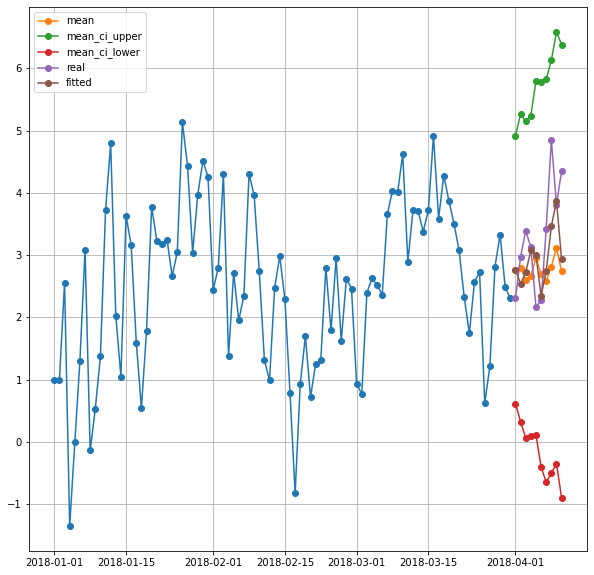

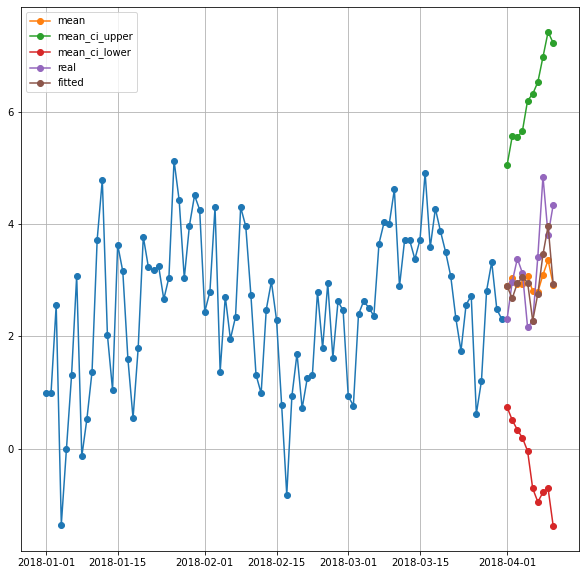

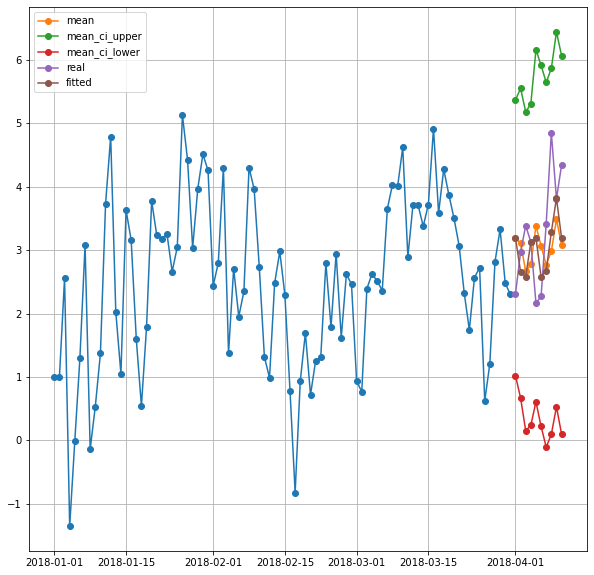

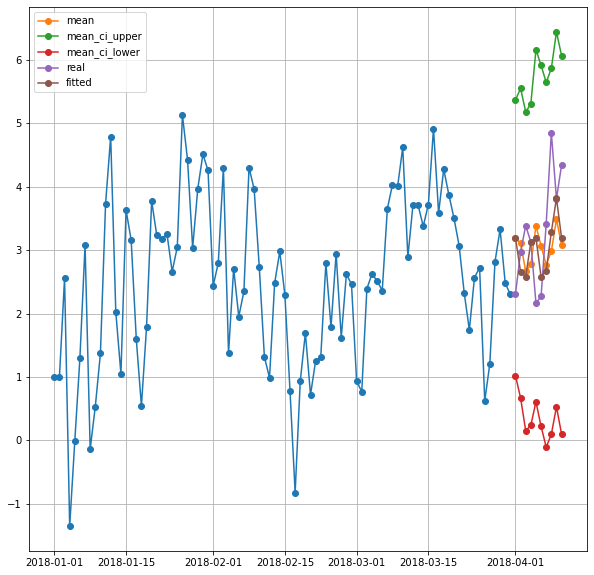

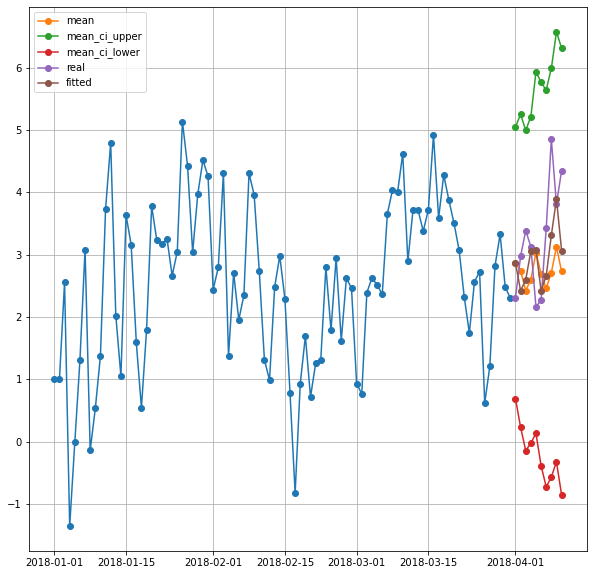

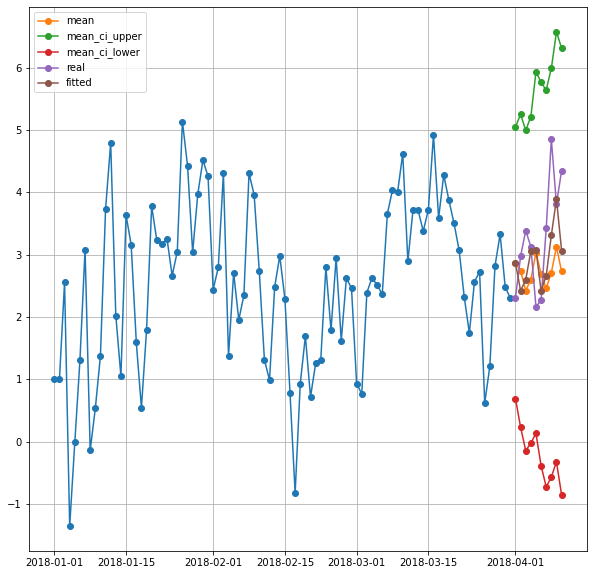

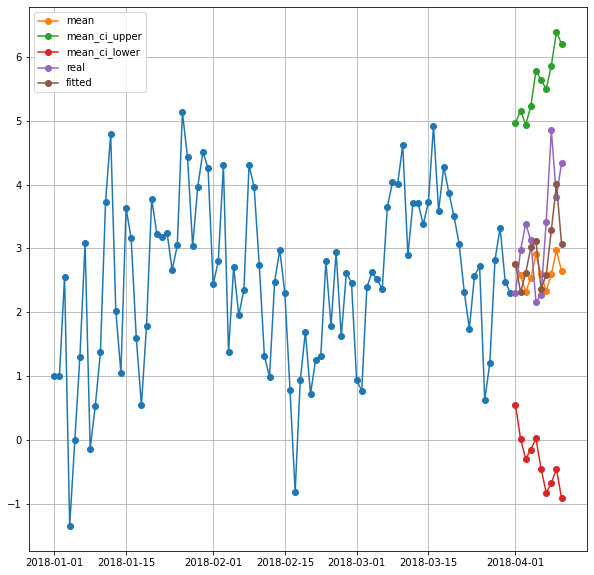

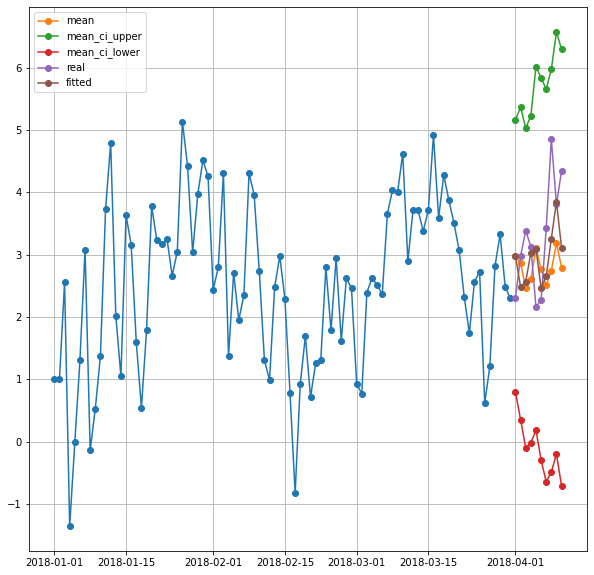

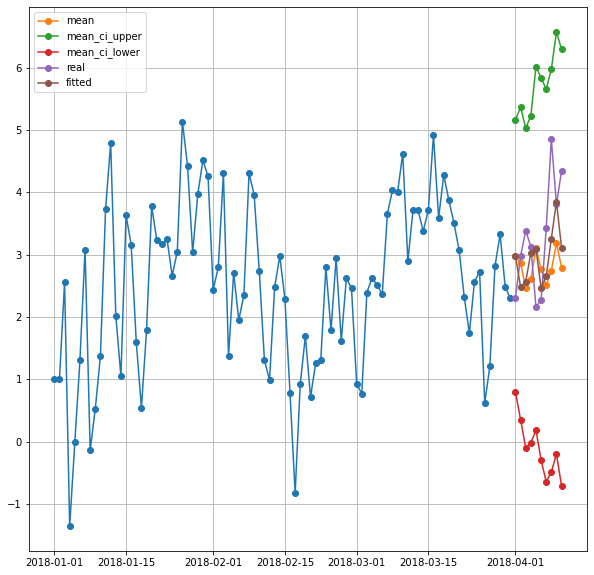

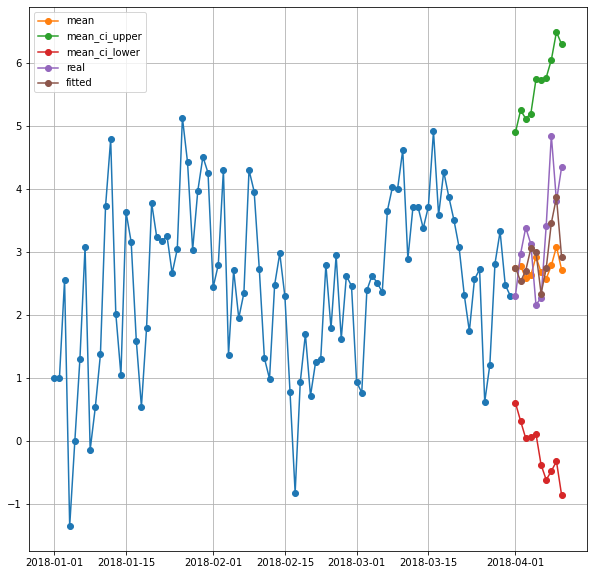

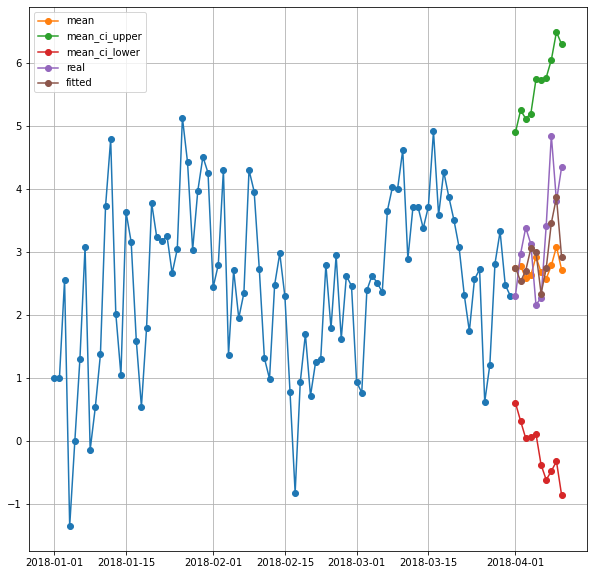

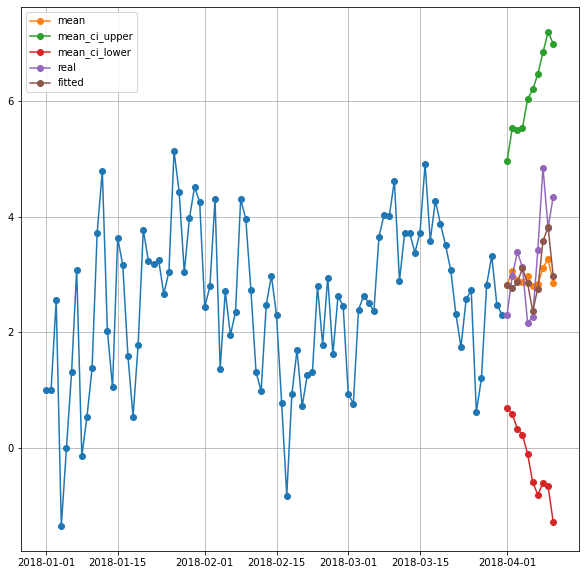

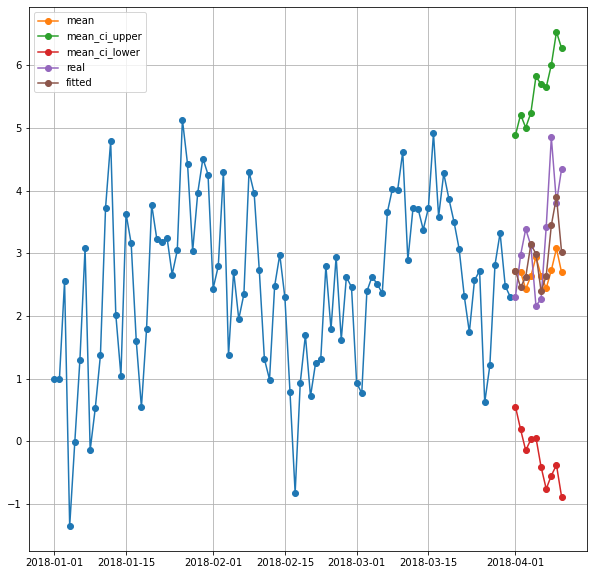

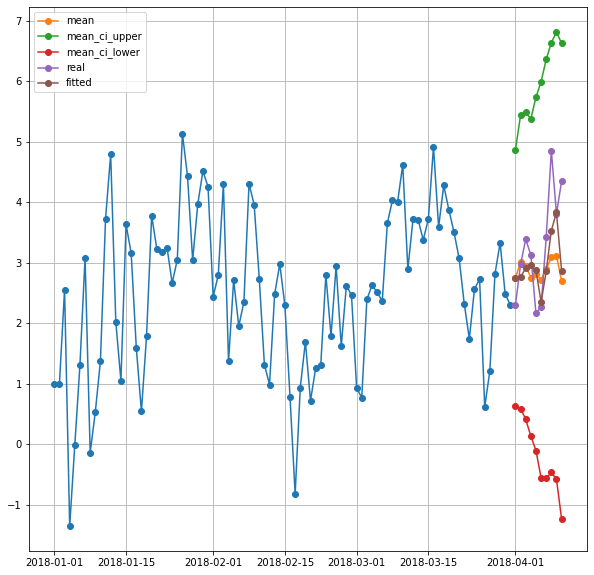

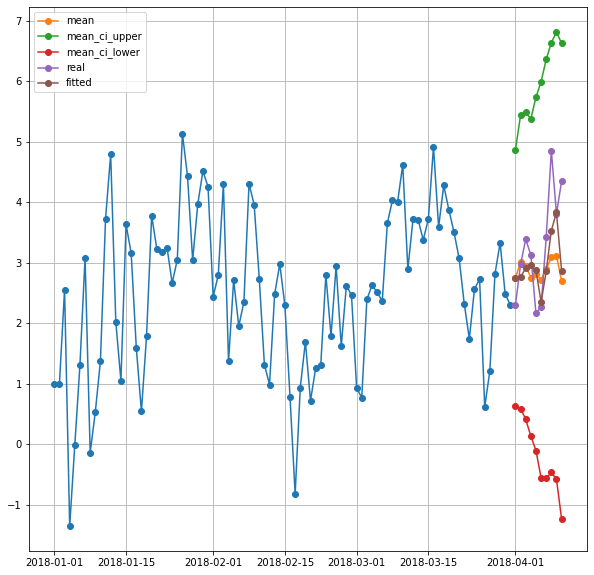

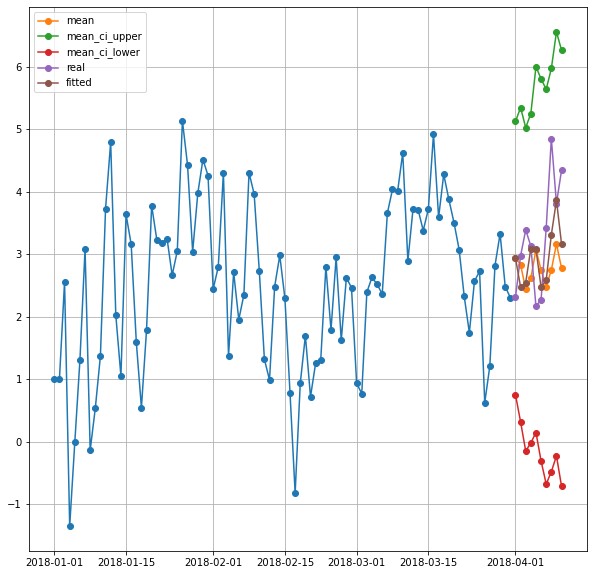

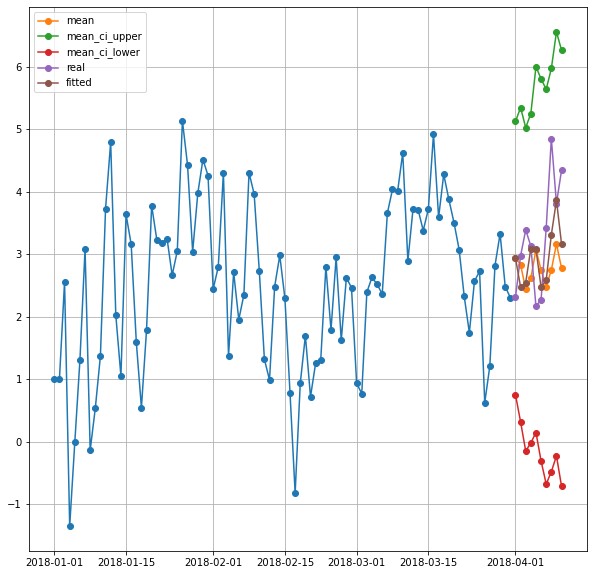

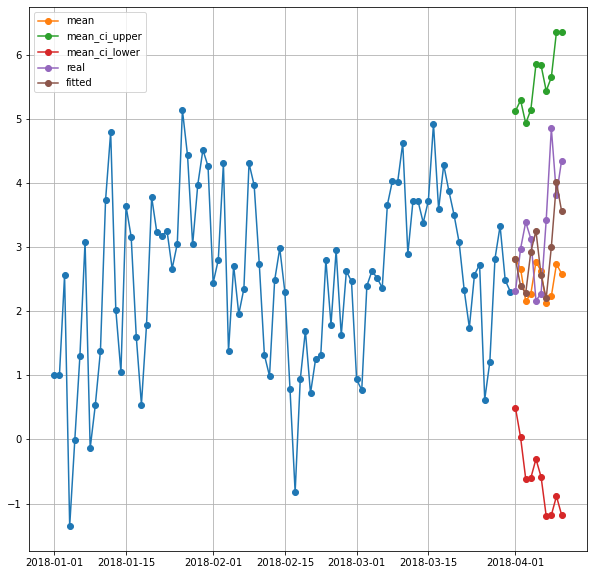

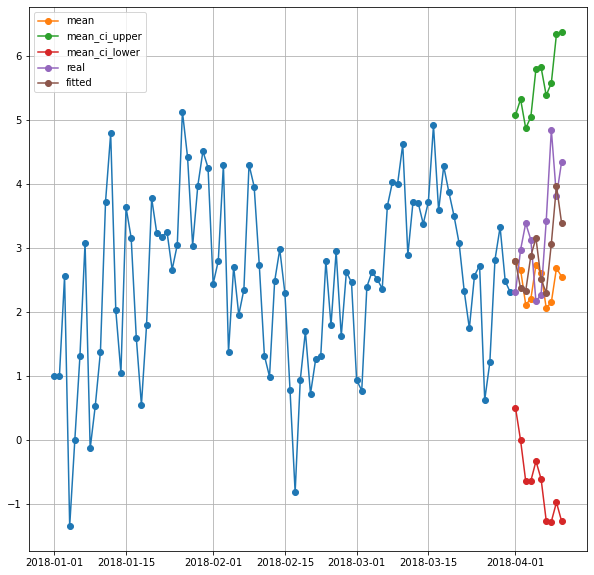

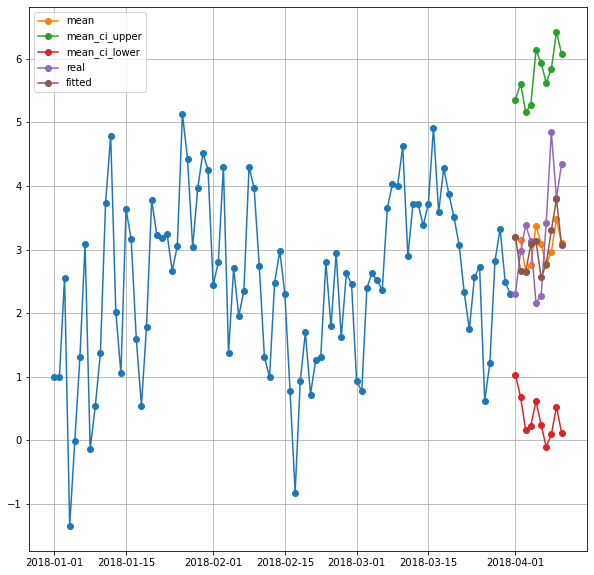

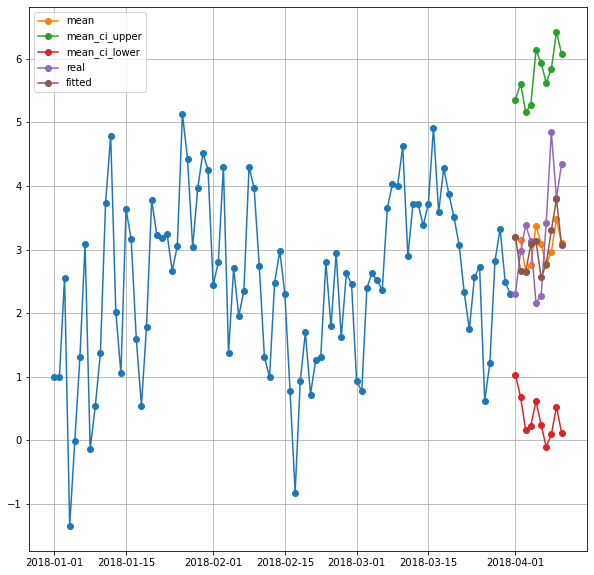

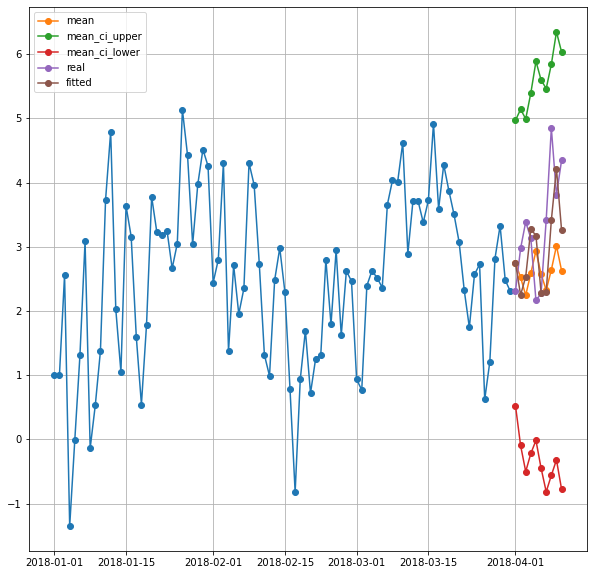

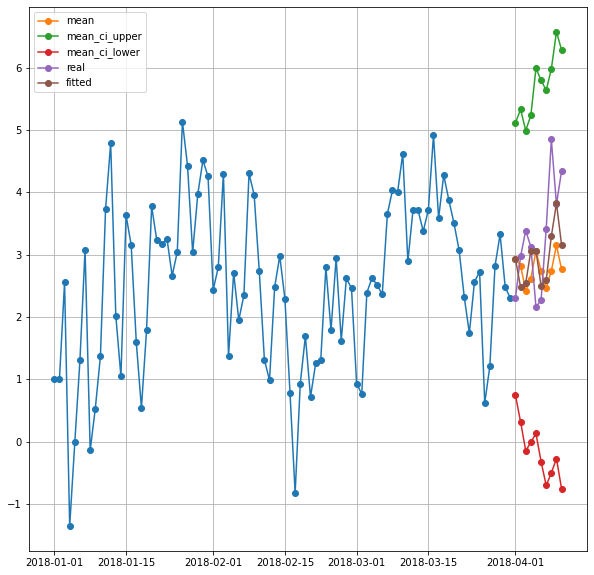

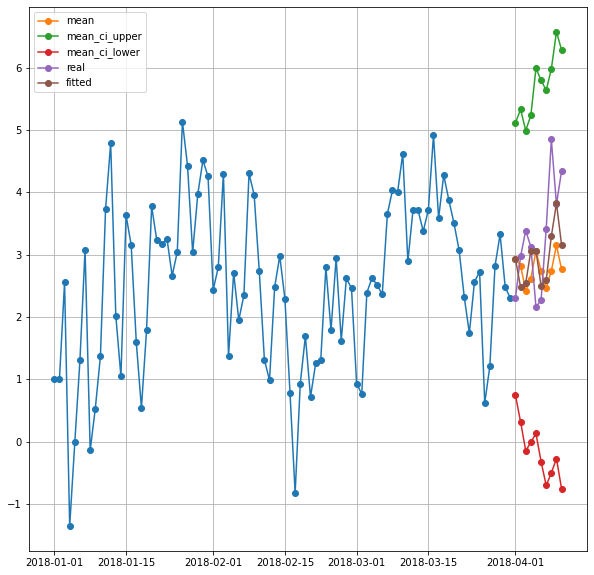

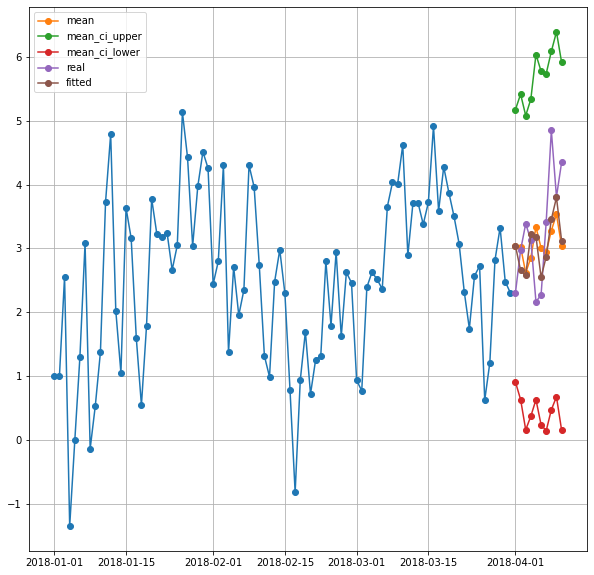

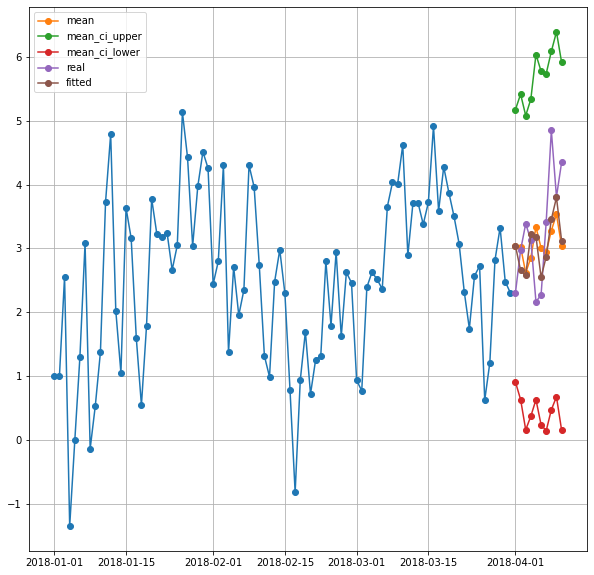

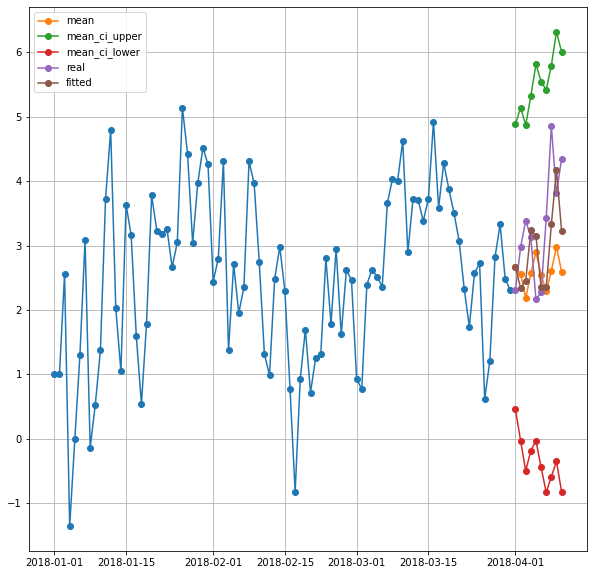

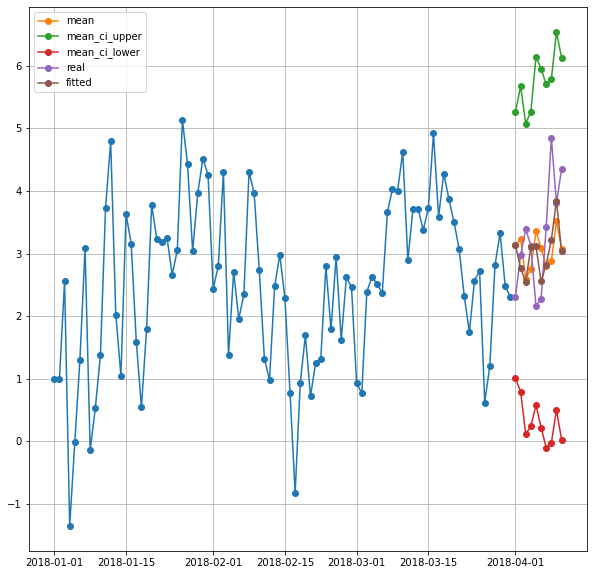

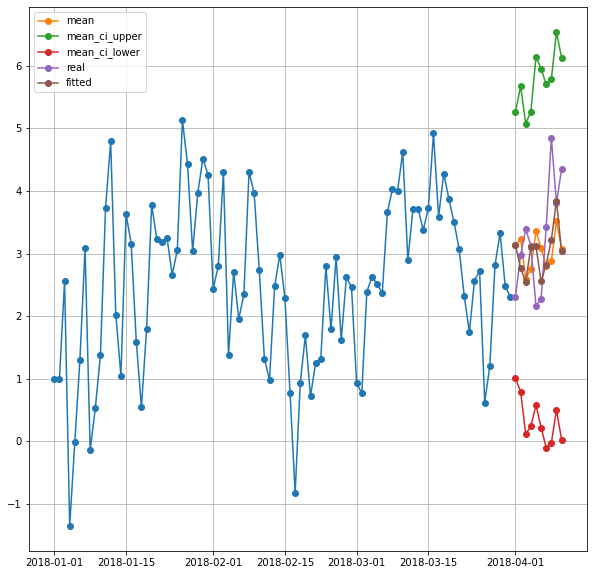

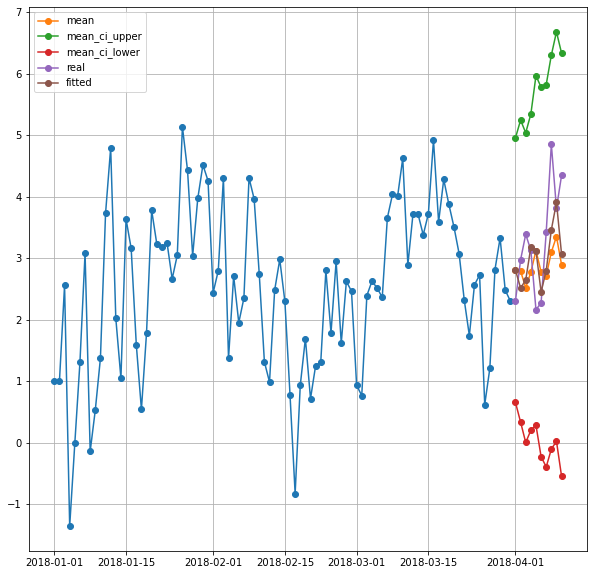

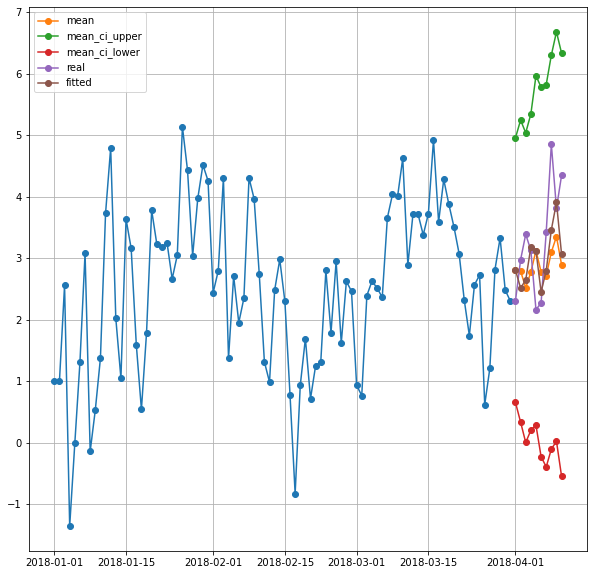

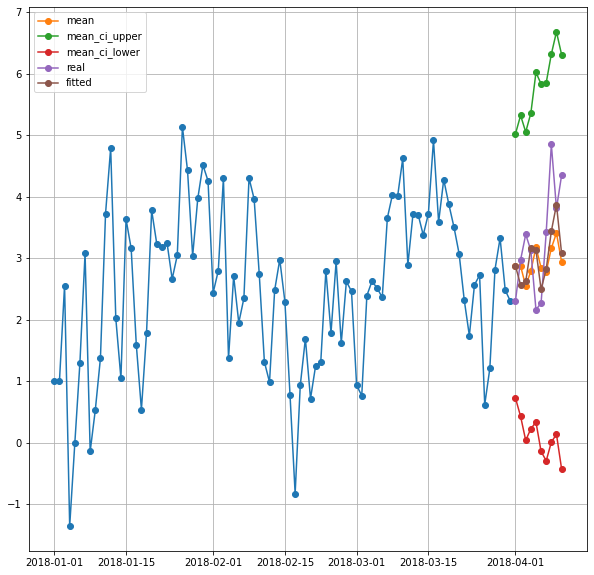

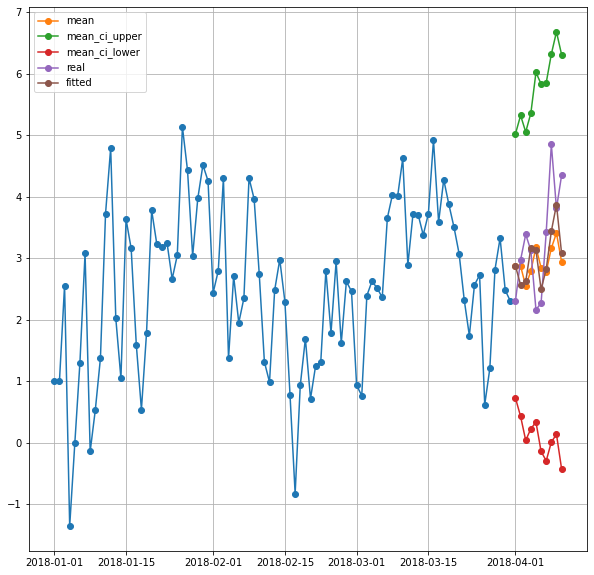

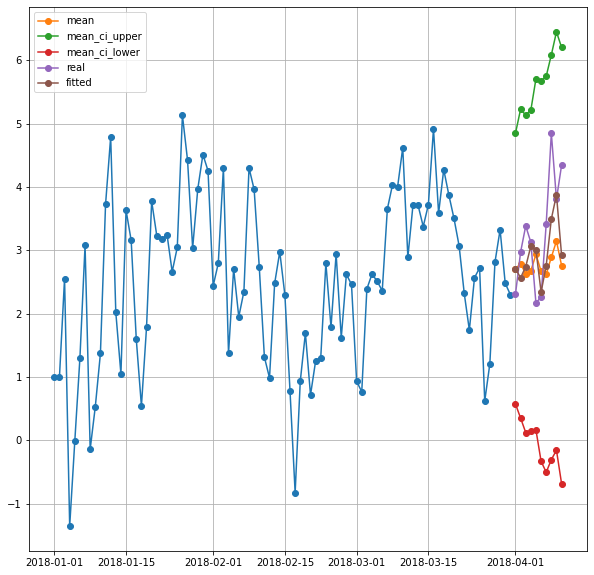

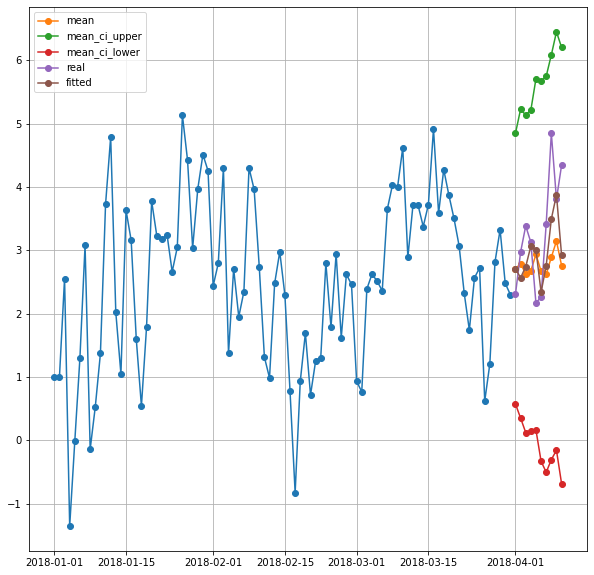

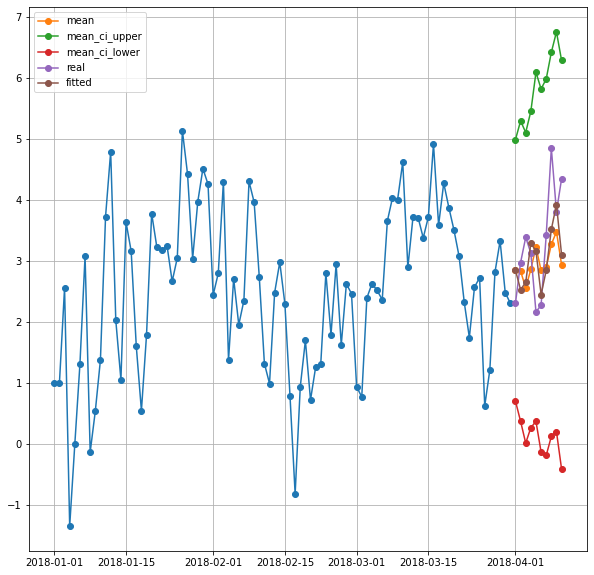

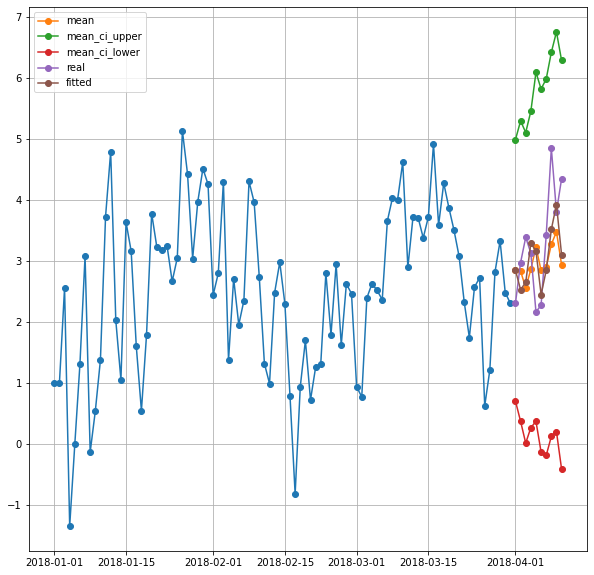

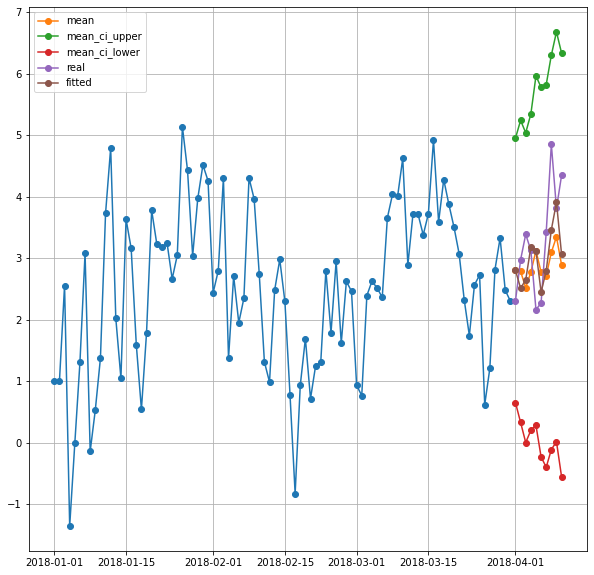

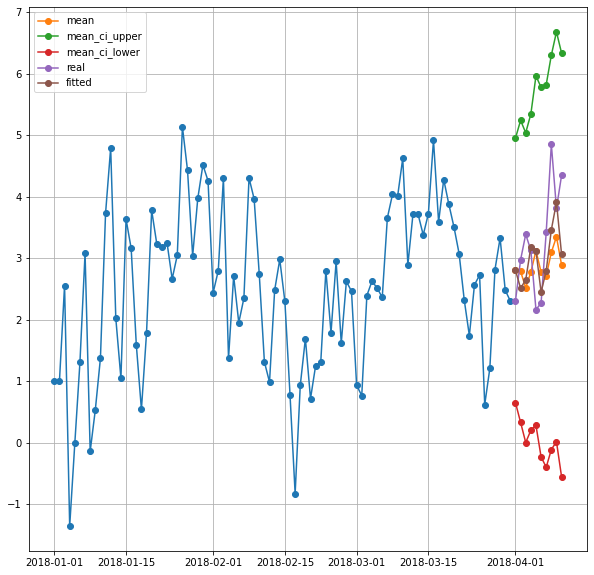

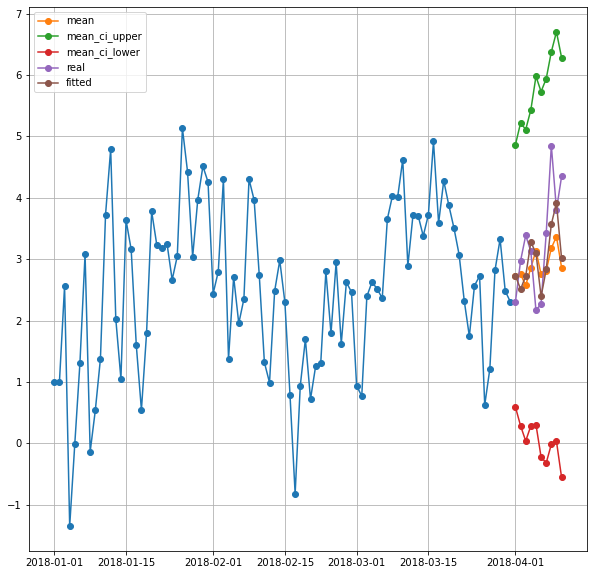

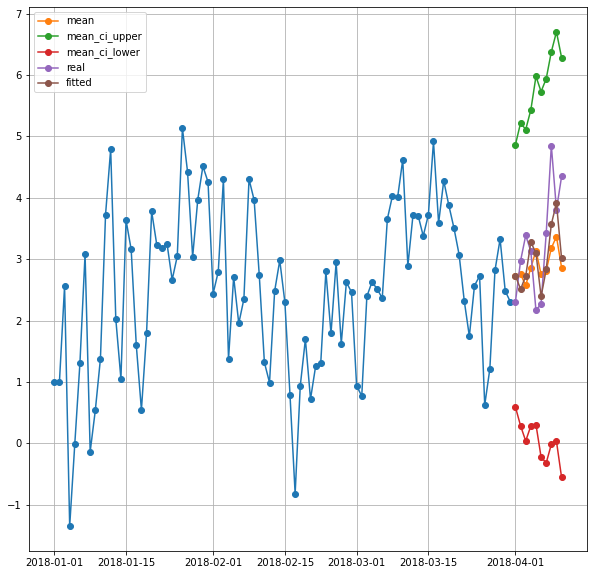

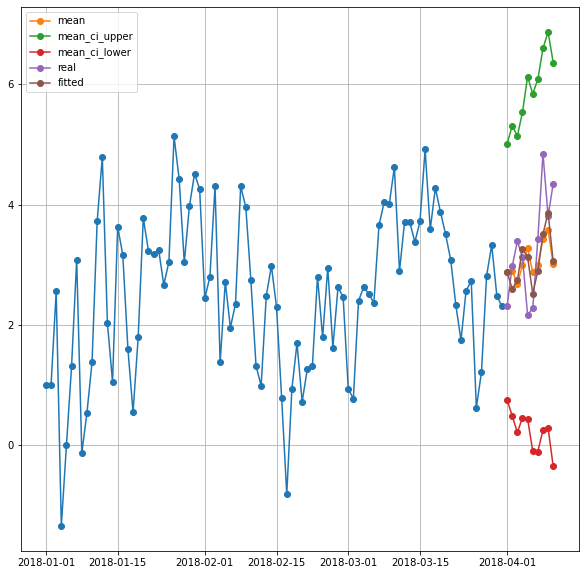

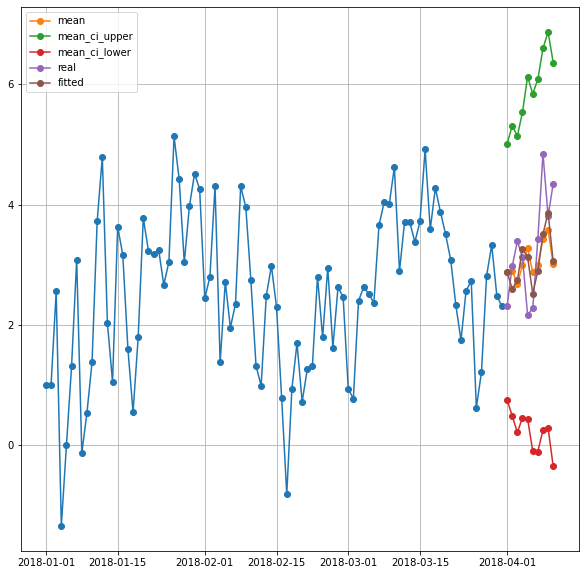

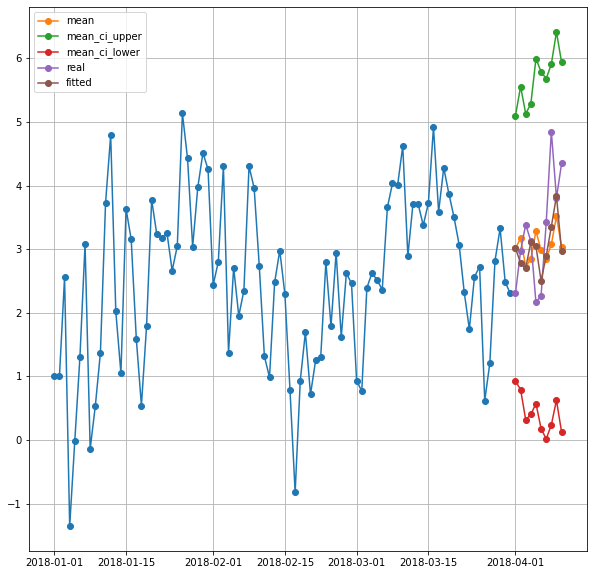

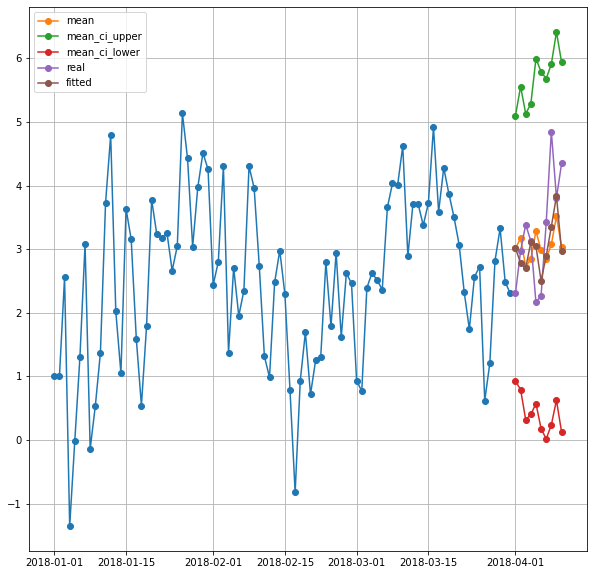

In [118]:
modelos.sort(key=lambda t:t.aicTotal)
import matplotlib.pyplot as plt
for modelo in modelos:
    #print(modelo.aicTotal,modelo.modelo.params,modelo.modelo.specification)
    #print(modelo.modelo.test_heteroskedasticity("breakvar",alternative= "two-sided"))
    #print(modelo.modelo.test_heteroskedasticity("breakvar",alternative= "increasing"))
    #print(modelo.modelo.test_normality(method="jarquebera"))
    u=(modelo.modelo.test_serial_correlation(method="ljungbox"))[0]
    dataframePred=modelo.modelo.get_forecast(len(serie_test)).summary_frame()
    dataframePred["real"]=serie_test   
    
    graficos.plot_forecast(serie_train,dataframePred,modelo.modeloExtendido.fittedvalues)